In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
from sklearn import svm
from sklearn.model_selection import KFold
from io import StringIO
import tensorflow as tf
import keras.backend as K
from keras.initializers import glorot_uniform
import seaborn as sns

#os.chdir('C:\\Users\\33785\\Maths\\STAGE LBPA\\PDB_DATA')

In [ ]:
class_weights = {0 : 2/3, 1 : 4/3, 2: 4/3}

tresh = 0.85

class My_Model:
  def __init__(self,model):
    self.model = model
    self.acc_train = []
    self.acc_test = []
    self.loss_acc = []
    self.loss_test = []

  def print_model(self):
    print(self.model.summary())


  def train(self,inputsA,inputsB,inputsA_test,inputsB_test,targets,targets_test,nb_split,nb_fold,nb_epochs,batch_size):
    kfold = KFold(n_splits=nb_split, shuffle=True)
    Losses = [0,0,0]
    acc_train = []
    acc_test = []
    loss_train = []
    loss_test = []
    for k in range(nb_fold):
        new_losses = [0,0,0]
        fold_no = 1

        c = 0
        for train, test in kfold.split(inputsA, targets):
            # Generate a print
            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ...')

            # Fit data to model
            history = self.model.fit(x = [inputsA[train],inputsB[train]], y = targets[train],
                      batch_size=batch_size,
                      epochs=nb_epochs,
                      class_weight = class_weights,
                              )

            # Generate generalization metrics
            scores = self.model.evaluate([inputsA[test],inputsB[test]], targets[test], verbose=0)
            scores_train = self.model.evaluate([inputsA,inputsB], targets, verbose=0)
            scores_test = self.model.evaluate([inputsA_test,inputsB_test], targets_test, verbose=0)
            loss_test.append(scores_test[0])
            acc_test.append(scores_test[1])
            loss_train.append(scores_train[0])
            acc_train.append(scores_train[1])
            new_losses[c] = scores[0]
            c += 1

            print(f'Score for fold {fold_no}: {self.model.metrics_names[0]} of {scores[0]}; {self.model.metrics_names[1]} of {scores[1]*100}%')

            # Increase fold number
            fold_no = fold_no + 1
        if scores_test[1] > 0.9:
          break
        if  new_losses == Losses:
            break
        else:
          Losses = new_losses
    self.acc_train = acc_train
    self.acc_test = acc_test
    self.loss_train = loss_train
    self.loss_test = loss_test

  def print_training(self):
    n = len(self.acc_train)
    t = np.linspace(1,10*n,n)
    plt.figure()
    plt.plot(t,self.loss_train,color = "blue",label = "train loss")
    plt.plot(t,self.loss_test,color = "green",label = "test loss")
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(t,self.acc_train,color = "blue",label = "train accuracy")
    plt.plot(t,self.acc_test,color = "green",label = "test accuracy")
    plt.legend()
    plt.show()



  def test(self,inputsA,inputsB,targets,batch_size):
    print("Evaluate on test data")
    results = self.model.evaluate([inputsA,inputsB],targets, batch_size=batch_size)
    print("test loss, test acc:", results)

  def plot_results(self,inputsA,inputsB,targets):
    predictions = self.model.predict([inputsA,inputsB])
    prob_pred = np.array([[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
    acc = [0,0,0]
    n_class = [0,0,0]
    for k in range(len(predictions)):
      label = int(targets[k])
      n_class[label] += 1
      pred = predictions[k]
      for i in range(3):
        prob_pred[label][i] = prob_pred[label][i] + pred[i]
      if np.argmax(pred) == label:
        acc[label] += 1
    for i in range(3):
      acc[i] = acc[i] / n_class[i]
      prob_pred[i] = prob_pred[i] / n_class[i]
    x = ["Parallèle \n"+str(n_class[0])+"  samples","Antiparallèle\n"+str(n_class[1])+"  samples","Hybride\n"+str(n_class[2])+"  samples"]
    sns.set_theme(style="white", context="talk")
    plt.figure()
    sns.barplot(x, acc, palette="deep")
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("Accuracy")

    # Finalize the plot
    sns.despine(bottom=True)
    plt.tight_layout(h_pad=2)
    print("\n ")
    sns.set_theme(style="white", context="talk")
    plt.figure()
    x = ["Parallèle" , "Antiparallèle","Hybride"]
    sns.barplot(x, prob_pred[0], palette="deep")
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("Probabilités")
    plt.title('Probabilités moyennes sur les prédictions parallèles')

    # Finalize the plot
    sns.despine(bottom=True)
    plt.tight_layout(h_pad=2)
    print("\n ")
    sns.set_theme(style="white", context="talk")
    plt.figure()
    x = ["Parallèle", "Antiparallèle", "Hybride"]
    sns.barplot(x, prob_pred[1], palette="deep")
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("Probabilités")
    plt.title('Probabilités sur les prédictions antiparallèles')

    # Finalize the plot
    sns.despine(bottom=True)
    plt.tight_layout(h_pad=2)
    print("\n ")
    sns.set_theme(style="white", context="talk")
    plt.figure()
    x = ["Parallèle" , "Antiparallèle", "Hybride"]
    sns.barplot(x, prob_pred[2], palette="deep")
    plt.axhline(0, color="k", clip_on=False)
    plt.ylabel("Probabilités")
    plt.title('Probabilités moyennes sur les prédictions hybrides')

    # Finalize the plot
    sns.despine(bottom=True)
    plt.tight_layout(h_pad=2)



class My_data:
  def __init__(self,data):
    self.data = data

  def shuffle(self):
    np.random.shuffle(self.data)


## Multi input

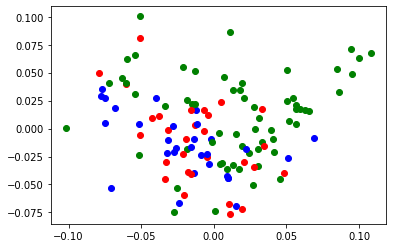

In [ ]:
from sklearn.decomposition import PCA

data_all = np.loadtxt("data_set_all_seq.txt")
data_pca = data_all[:,:-5]
pca = PCA(n_components = 2)
Xpca = pca.fit_transform(data_pca)


colors = ["green","blue","red"]

plt.figure()
for k in range (len(data_all)):
  plt.scatter(Xpca[k,0],Xpca[k,1],color = colors[int(data_all[k,-1])])

In [ ]:
data = My_data(np.loadtxt("data_set_all_seq.txt"))

def create_data1(data,nb_train):
  X1 = data[:,:-5]
  X2 = data[:,-5:-1]
  Y = data[:,-1]
  return X1[:nb_train],X2[:nb_train],Y[:nb_train],X1[nb_train:],X2[nb_train:],Y[nb_train:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Softmax


#DNN

In [ ]:

def create_model1():
  # define two sets of inputs
  inputA = Input(shape=(99,))
  inputB = Input(shape=(4,))

  # the first branch operates on the first input
  x = Dense(6, activation="relu")(inputA)
  x = Model(inputs=inputA, outputs=x)

  # the second branch opreates on the second input
  y = Dense(4, activation="relu")(inputB)
  y = Model(inputs=inputB, outputs=y)

  # combine the output of the two branches
  combined = concatenate([x.output, y.output])
  # apply a FC layer and then a regression prediction on the
  # combined outputs
  z = Dense(5, activation="relu")(combined)
  z = Dense(5, activation="relu")(z)
  z = Dense(3, activation="relu")(z)
  z = Softmax()(z)

  # our model will accept the inputs of the two branches

  multi_model = Model(inputs=[x.input, y.input], outputs=z)

  multi_model.compile(
      optimizer= tf.keras.optimizers.Adam(
      learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
      name='Adam'
  ),  # Optimizer
      # Loss function to minimize
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      # List of metrics to monitor
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )

  return My_Model(multi_model)


In [ ]:
## train

data.shuffle()

multi_model = create_model1()


nb_train = 90

inputsA_train, inputsB_train, targets_train, inputsA_test, inputsB_test, targets_test  = create_data1(data.data,nb_train)

multi_model.train(inputsA_train,inputsB_train,targets_train,2,3,40,2)

print('\n \n TEST : \n \n')

multi_model.test(inputsA_test,inputsB_test,targets_test,1)



------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
23/23 [==============================] - 1s 2ms/step - loss: 1.1212 - sparse_categorical_accuracy: 0.2222
Epoch 2/40
23/23 [==============================] - 0s 2ms/step - loss: 1.0841 - sparse_categorical_accuracy: 0.2667
Epoch 3/40
23/23 [==============================] - 0s 2ms/step - loss: 1.0635 - sparse_categorical_accuracy: 0.3111
Epoch 4/40
23/23 [==============================] - 0s 2ms/step - loss: 1.0524 - sparse_categorical_accuracy: 0.2667
Epoch 5/40
23/23 [==============================] - 0s 2ms/step - loss: 1.0470 - sparse_categorical_accuracy: 0.2667
Epoch 6/40
23/23 [==============================] - 0s 2ms/step - loss: 1.0445 - sparse_categorical_accuracy: 0.2444
Epoch 7/40
23/23 [==============================] - 0s 2ms/step - loss: 1.0410 - sparse_categorical_accuracy: 0.2889
Epoch 8/40
23/23 [==============================] - 0s 2ms/step - loss: 1.0372 - spa

## HYPER PARAMETERS

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 209 kB 51.6 MB/s 
     |████████████████████████████████| 80 kB 9.4 MB/s 
     |████████████████████████████████| 75 kB 4.7 MB/s 
     |████████████████████████████████| 149 kB 30.8 MB/s 
     |████████████████████████████████| 112 kB 61.5 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=fbed39fcfd78d5f1eb1bef431aa62c1421c5ebef5c6696585f225419a15f0f47
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

def objective(trial):
    n2 = trial.suggest_int('n2',4,8)
    n_iter = trial.suggest_int('n_iter', 1,10)
    learning_rate = trial.suggest_float('learning_rate', 0.00001,0.1)
    acc = []
    data = np.loadtxt("data_set_all_seq.txt")
    for n in range(10):
        np.random.shuffle(data)

        X = data[:,:-1]
        Y = data[:,-1]

        inputsA = data[:90,:-5]
        inputsB = data[:90,-5:-1]
        target = data[:90,-1]

        # define two sets of inputs
        inputA = Input(shape=(99,))
        inputB = Input(shape=(4,))

        # the first branch operates on the first input
        x = Dense(8, activation="relu")(inputA)
        x = Model(inputs=inputA, outputs=x)

        # the second branch opreates on the second input
        y = Dense(n2, activation="relu")(inputB)
        y = Model(inputs=inputB, outputs=y)

        # combine the output of the two branches
        combined = concatenate([x.output, y.output])
        # apply a FC layer and then a regression prediction on the
        # combined outputs
        z = Dense(6, activation="relu")(combined)
        z = Dense(6, activation="relu")(z)
        z = Dense(3, activation="relu")(z)
        z = Softmax()(z)

        # our model will accept the inputs of the two branches

        multi_model = Model(inputs=[x.input, y.input], outputs=z)

        multi_model.compile(
            optimizer= tf.keras.optimizers.Adam(
            learning_rate= learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
            name='Adam'
        ),  # Optimizer
            # Loss function to minimize
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            # List of metrics to monitor
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
        )

        # Define the K-fold Cross Validator
        kfold = KFold(n_splits=2, shuffle=True)

        for k in range(n_iter):
            fold_no = 1
            for train, test in kfold.split(inputsA, target):

                # Fit data to model
                multi_model.fit(x = [inputsA[train],inputsB[train]], y = target[train],
                          batch_size=3,
                          epochs=40,
                          verbose = 0
                                   )

                # Increase fold number
                fold_no = fold_no + 1

        #test accuracy

        XA_test = data[90:,:-5]
        XB_test = data[90:,-5:-1]
        Y_test = Y[90:]

        results = multi_model.evaluate([XA_test,XB_test], Y_test, batch_size=1)

        acc += [results[1]]
    return np.max(acc)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2021-12-02 13:15:39,197] A new study created in memory with name: no-name-ee40c024-83c2-4f34-bea0-209232e707d3


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4516


[I 2021-12-02 13:18:11,563] Trial 0 finished with value: 0.6129032373428345 and parameters: {'n2': 6, 'n_iter': 6, 'learning_rate': 0.04648711791341041}. Best is trial 0 with value: 0.6129032373428345.


31/31 [==============================] - 0s 2ms/step - loss: 0.7247 - sparse_categorical_accuracy: 0.4839


[I 2021-12-02 13:18:43,506] Trial 1 finished with value: 0.6774193644523621 and parameters: {'n2': 8, 'n_iter': 1, 'learning_rate': 0.014804438452576625}. Best is trial 1 with value: 0.6774193644523621.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5484


[I 2021-12-02 13:20:44,794] Trial 2 finished with value: 0.6129032373428345 and parameters: {'n2': 8, 'n_iter': 5, 'learning_rate': 0.08447304202117482}. Best is trial 1 with value: 0.6774193644523621.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4516


[I 2021-12-02 13:22:27,430] Trial 3 finished with value: 0.6451612710952759 and parameters: {'n2': 7, 'n_iter': 4, 'learning_rate': 0.07626135341922954}. Best is trial 1 with value: 0.6774193644523621.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4839


[I 2021-12-02 13:26:09,855] Trial 4 finished with value: 0.7096773982048035 and parameters: {'n2': 8, 'n_iter': 9, 'learning_rate': 0.04974503357330159}. Best is trial 4 with value: 0.7096773982048035.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5484


[I 2021-12-02 13:28:39,358] Trial 5 finished with value: 0.6451612710952759 and parameters: {'n2': 5, 'n_iter': 6, 'learning_rate': 0.04450465203021972}. Best is trial 4 with value: 0.7096773982048035.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.3871


[I 2021-12-02 13:29:33,478] Trial 6 finished with value: 0.6129032373428345 and parameters: {'n2': 5, 'n_iter': 2, 'learning_rate': 0.08627845485723018}. Best is trial 4 with value: 0.7096773982048035.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4516


[I 2021-12-02 13:33:41,638] Trial 7 finished with value: 0.8387096524238586 and parameters: {'n2': 5, 'n_iter': 10, 'learning_rate': 0.01718748273903961}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 1ms/step - loss: 0.9951 - sparse_categorical_accuracy: 0.5806


[I 2021-12-02 13:37:47,804] Trial 8 finished with value: 0.6129032373428345 and parameters: {'n2': 7, 'n_iter': 10, 'learning_rate': 0.09276331732648853}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 2ms/step - loss: 0.9953 - sparse_categorical_accuracy: 0.4839 


[I 2021-12-02 13:41:29,530] Trial 9 finished with value: 0.7419354915618896 and parameters: {'n2': 7, 'n_iter': 9, 'learning_rate': 0.012051824444548803}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 1ms/step - loss: 1.1072 - sparse_categorical_accuracy: 0.3871


[I 2021-12-02 13:44:47,094] Trial 10 finished with value: 0.6451612710952759 and parameters: {'n2': 4, 'n_iter': 8, 'learning_rate': 1.821216540397186e-05}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.6452


[I 2021-12-02 13:48:16,354] Trial 11 finished with value: 0.7419354915618896 and parameters: {'n2': 6, 'n_iter': 8, 'learning_rate': 0.024316573495825933}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4516


[I 2021-12-02 13:52:30,876] Trial 12 finished with value: 0.6451612710952759 and parameters: {'n2': 4, 'n_iter': 10, 'learning_rate': 0.028925775971903062}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 3ms/step - loss: 1.3310 - sparse_categorical_accuracy: 0.6129


[I 2021-12-02 13:55:58,322] Trial 13 finished with value: 0.7419354915618896 and parameters: {'n2': 5, 'n_iter': 8, 'learning_rate': 0.0059469652228234665}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.6452


[I 2021-12-02 14:00:10,132] Trial 14 finished with value: 0.6774193644523621 and parameters: {'n2': 7, 'n_iter': 10, 'learning_rate': 0.0298763648140007}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4839


[I 2021-12-02 14:03:06,808] Trial 15 finished with value: 0.7419354915618896 and parameters: {'n2': 6, 'n_iter': 7, 'learning_rate': 0.06933498791831513}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4839


[I 2021-12-02 14:06:50,316] Trial 16 finished with value: 0.6129032373428345 and parameters: {'n2': 5, 'n_iter': 9, 'learning_rate': 0.015513014925200264}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.3871


[I 2021-12-02 14:09:43,783] Trial 17 finished with value: 0.7419354915618896 and parameters: {'n2': 5, 'n_iter': 7, 'learning_rate': 0.0034276039520009607}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 2ms/step - loss: 1.0015 - sparse_categorical_accuracy: 0.5484


[I 2021-12-02 14:11:24,826] Trial 18 finished with value: 0.6774193644523621 and parameters: {'n2': 4, 'n_iter': 4, 'learning_rate': 0.06058374252976898}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.6452


[I 2021-12-02 14:14:59,629] Trial 19 finished with value: 0.6451612710952759 and parameters: {'n2': 7, 'n_iter': 9, 'learning_rate': 0.038788589303472315}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 2ms/step - loss: 1.2828 - sparse_categorical_accuracy: 0.7419


[I 2021-12-02 14:17:50,442] Trial 20 finished with value: 0.8064516186714172 and parameters: {'n2': 6, 'n_iter': 7, 'learning_rate': 0.014062617153559373}. Best is trial 7 with value: 0.8387096524238586.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.6452


[I 2021-12-02 14:20:42,250] Trial 21 finished with value: 0.8709677457809448 and parameters: {'n2': 5, 'n_iter': 7, 'learning_rate': 0.021542399983953447}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.2711 - sparse_categorical_accuracy: 0.4839


[I 2021-12-02 14:23:37,691] Trial 22 finished with value: 0.6129032373428345 and parameters: {'n2': 6, 'n_iter': 7, 'learning_rate': 0.021547126390357697}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 1ms/step - loss: 0.9442 - sparse_categorical_accuracy: 0.6774


[I 2021-12-02 14:25:43,311] Trial 23 finished with value: 0.8387096524238586 and parameters: {'n2': 5, 'n_iter': 5, 'learning_rate': 0.03193804423424743}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 1ms/step - loss: 5.0468 - sparse_categorical_accuracy: 0.3548


[I 2021-12-02 14:27:28,442] Trial 24 finished with value: 0.6451612710952759 and parameters: {'n2': 5, 'n_iter': 4, 'learning_rate': 0.03785080642154688}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5806


[I 2021-12-02 14:28:45,453] Trial 25 finished with value: 0.6774193644523621 and parameters: {'n2': 4, 'n_iter': 3, 'learning_rate': 0.03350671614484446}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5484


[I 2021-12-02 14:30:49,736] Trial 26 finished with value: 0.5806451439857483 and parameters: {'n2': 5, 'n_iter': 5, 'learning_rate': 0.05977110539874577}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5484


[I 2021-12-02 14:33:15,545] Trial 27 finished with value: 0.6451612710952759 and parameters: {'n2': 4, 'n_iter': 6, 'learning_rate': 0.022860224957597982}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4839


[I 2021-12-02 14:34:32,664] Trial 28 finished with value: 0.5483871102333069 and parameters: {'n2': 5, 'n_iter': 3, 'learning_rate': 0.0566190921384005}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5161


[I 2021-12-02 14:37:02,154] Trial 29 finished with value: 0.6129032373428345 and parameters: {'n2': 6, 'n_iter': 6, 'learning_rate': 0.03973872162201455}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.3080 - sparse_categorical_accuracy: 0.7419


[I 2021-12-02 14:39:07,911] Trial 30 finished with value: 0.7419354915618896 and parameters: {'n2': 5, 'n_iter': 5, 'learning_rate': 0.009621404067330662}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 0.7842 - sparse_categorical_accuracy: 0.4839


[I 2021-12-02 14:41:59,132] Trial 31 finished with value: 0.774193525314331 and parameters: {'n2': 6, 'n_iter': 7, 'learning_rate': 0.019855412159288797}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5484


[I 2021-12-02 14:44:29,328] Trial 32 finished with value: 0.6774193644523621 and parameters: {'n2': 6, 'n_iter': 6, 'learning_rate': 0.016449903185310817}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4839


[I 2021-12-02 14:47:43,687] Trial 33 finished with value: 0.6451612710952759 and parameters: {'n2': 5, 'n_iter': 8, 'learning_rate': 0.029027850489702134}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5484


[I 2021-12-02 14:48:16,102] Trial 34 finished with value: 0.8709677457809448 and parameters: {'n2': 6, 'n_iter': 1, 'learning_rate': 0.009341207439452189}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 0.6766 - sparse_categorical_accuracy: 0.7419


[I 2021-12-02 14:48:47,300] Trial 35 finished with value: 0.7419354915618896 and parameters: {'n2': 4, 'n_iter': 1, 'learning_rate': 0.007984754600129203}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5161


[I 2021-12-02 14:49:18,389] Trial 36 finished with value: 0.7096773982048035 and parameters: {'n2': 5, 'n_iter': 1, 'learning_rate': 0.045647278996264154}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.5484


[I 2021-12-02 14:50:12,368] Trial 37 finished with value: 0.6129032373428345 and parameters: {'n2': 8, 'n_iter': 2, 'learning_rate': 0.026479767526935823}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0569 - sparse_categorical_accuracy: 0.6452


[I 2021-12-02 14:51:31,965] Trial 38 finished with value: 0.6451612710952759 and parameters: {'n2': 6, 'n_iter': 3, 'learning_rate': 0.01963781099389769}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4516


[I 2021-12-02 14:52:28,366] Trial 39 finished with value: 0.6451612710952759 and parameters: {'n2': 5, 'n_iter': 2, 'learning_rate': 0.034250470359034516}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 1ms/step - loss: 0.7546 - sparse_categorical_accuracy: 0.6774


[I 2021-12-02 14:54:10,483] Trial 40 finished with value: 0.8064516186714172 and parameters: {'n2': 6, 'n_iter': 4, 'learning_rate': 0.0020158657032038185}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 1ms/step - loss: 1.0105 - sparse_categorical_accuracy: 0.4516


[I 2021-12-02 14:56:15,494] Trial 41 finished with value: 0.7096773982048035 and parameters: {'n2': 6, 'n_iter': 5, 'learning_rate': 0.012868448583921919}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4839


[I 2021-12-02 14:59:09,240] Trial 42 finished with value: 0.6451612710952759 and parameters: {'n2': 7, 'n_iter': 7, 'learning_rate': 0.015688354825498713}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 0.7934 - sparse_categorical_accuracy: 0.7742


[I 2021-12-02 15:00:54,852] Trial 43 finished with value: 0.8387096524238586 and parameters: {'n2': 5, 'n_iter': 4, 'learning_rate': 0.004665442103005367}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.3261 - sparse_categorical_accuracy: 0.7742


[I 2021-12-02 15:03:01,039] Trial 44 finished with value: 0.8064516186714172 and parameters: {'n2': 5, 'n_iter': 5, 'learning_rate': 0.008397916410114429}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0335 - sparse_categorical_accuracy: 0.5484


[I 2021-12-02 15:04:17,664] Trial 45 finished with value: 0.7096773982048035 and parameters: {'n2': 5, 'n_iter': 3, 'learning_rate': 6.266197722736011e-05}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.4085 - sparse_categorical_accuracy: 0.4516


[I 2021-12-02 15:05:57,090] Trial 46 finished with value: 0.774193525314331 and parameters: {'n2': 4, 'n_iter': 4, 'learning_rate': 0.007459438714137009}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.6129


[I 2021-12-02 15:06:53,745] Trial 47 finished with value: 0.774193525314331 and parameters: {'n2': 5, 'n_iter': 2, 'learning_rate': 0.024265926591557973}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 1ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.4839


[I 2021-12-02 15:10:08,304] Trial 48 finished with value: 0.7096773982048035 and parameters: {'n2': 5, 'n_iter': 8, 'learning_rate': 0.09976365322130328}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.2129 - sparse_categorical_accuracy: 0.5806


[I 2021-12-02 15:12:36,008] Trial 49 finished with value: 0.8064516186714172 and parameters: {'n2': 4, 'n_iter': 6, 'learning_rate': 0.0184802444339286}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 2.1563 - sparse_categorical_accuracy: 0.8065


[I 2021-12-02 15:16:16,267] Trial 50 finished with value: 0.8064516186714172 and parameters: {'n2': 5, 'n_iter': 9, 'learning_rate': 0.012020660203645887}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.0396 - sparse_categorical_accuracy: 0.7419 


[I 2021-12-02 15:20:16,854] Trial 51 finished with value: 0.8064516186714172 and parameters: {'n2': 5, 'n_iter': 10, 'learning_rate': 0.005062699186768411}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.2261 - sparse_categorical_accuracy: 0.5161


[I 2021-12-02 15:24:16,384] Trial 52 finished with value: 0.7419354915618896 and parameters: {'n2': 5, 'n_iter': 10, 'learning_rate': 0.0041236232882435105}. Best is trial 21 with value: 0.8709677457809448.


31/31 [==============================] - 0s 2ms/step - loss: 1.1313 - sparse_categorical_accuracy: 0.5806


[I 2021-12-02 15:25:59,608] Trial 53 finished with value: 0.774193525314331 and parameters: {'n2': 6, 'n_iter': 4, 'learning_rate': 0.0006462775314646438}. Best is trial 21 with value: 0.8709677457809448.


 1/31 [..............................] - ETA: 4s - loss: 1.0986 - sparse_categorical_accuracy: 0.0000e+00

# Multi modal CNN

In [ ]:
def create_data2(data,nb_train):
  data_cnn = []
  for k in range(len(data)):
      sample = []
      for i in range (len(data[0])-5):
          sample.append([data[k,i]])
      data_cnn.append(sample)
  data_cnn = np.array(data_cnn)
  inputs_cnn = data_cnn[:nb_train,:]
  inputs_nuc = data_cnn[:nb_train,-5:-1]
  target_cnn = data[:nb_train,-1]

  inputs_cnn_test = data_cnn[nb_train:,:]
  inputs_nuc_test = data_cnn[nb_train:,-5:-1]
  target_cnn_test = data[nb_train:,-1]
  return inputs_cnn, inputs_nuc, target_cnn, inputs_cnn_test, inputs_nuc_test, target_cnn_test


In [ ]:

def create_model2():
  # define two sets of inputs
  inputA = Input(shape=(99,1))
  inputB = Input(shape=(4,))

  # the first branch operates on the first input
  model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(4,10, activation='relu',input_shape = (99,1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu')
  ])

  #x = Model(inputs=inputA, outputs = model_cnn.output)

  # the second branch opreates on the second input
  y = Dense(8, activation="relu")(inputB)
  y = Model(inputs=inputB, outputs=y)



  # combine the output of the two branches
  combined = concatenate([model_cnn.output, y.output])
  # apply a FC layer and then a regression prediction on the
  # combined outputs
  z = Dense(16, activation="relu")(combined)
  z = Dense(3, activation="relu")(z)
  z = Softmax()(z)

  # our model will accept the inputs of the two branches

  multi_model_cnn = Model(inputs=[model_cnn.input, y.input], outputs=z)

  multi_model_cnn.compile(
      optimizer= "adam",  # Optimizer
      # Loss function to minimize
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      # List of metrics to monitor
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )
  return My_Model(multi_model_cnn)



In [ ]:
## shuffle data set

data.shuffle()


In [ ]:
##initialize the model

multi_model_cnn = create_model2()

#multi_model_cnn.print_model()

In [ ]:
score = 0
while score < 0.9:
  data.shuffle()
  multi_model_cnn = create_model2()

  nb_train = 90


  inputsA_train, inputsB_train, targets_train, inputsA_test, inputsB_test, targets_test  = create_data2(data.data,nb_train)

  multi_model_cnn.train(inputsA_train,inputsB_train,inputsA_test,inputsB_test,targets_train,targets_test,3,12,10,3)
  score = multi_model_cnn.model.evaluate([inputsA_test,inputsB_test],targets_test,1)[1]


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Score for fold 2: loss of 0.3824576139450073; sparse_categorical_accuracy of 69.9999988079071%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/10
20/20 [==============================] - 0s 4ms/step - loss: 0.4231 - sparse_categorical_accuracy: 0.7500
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4185 - sparse_categorical_accuracy: 0.7500
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4164 - sparse_categorical_accuracy: 0.7500
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4163 - sparse_categorical_accuracy: 0.7500
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4162 - sparse_categorical_accuracy: 0.7500
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4182 - sparse_categorical_accuracy: 0.7500
Epoch 7/10
20/20 [==========

In [ ]:
# model = tf.keras.models.load_model("/content/drive/MyDrive/stage_lbpa/model/multimodal2")

print('\n \n TEST : \n \n')
multi_model_cnn.test(inputsA_test,inputsB_test,targets_test,1)


 
 TEST : 
 

Evaluate on test data
31/31 [==============================] - 0s 2ms/step - loss: 0.2954 - sparse_categorical_accuracy: 0.9032
test loss, test acc: [0.29539191722869873, 0.9032257795333862]


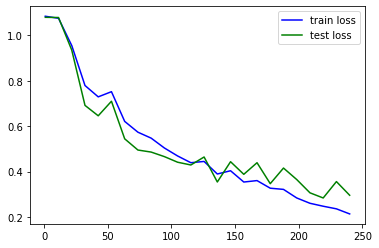

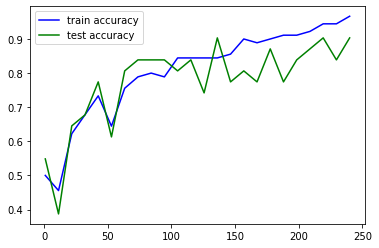

In [ ]:
multi_model_cnn.print_training()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


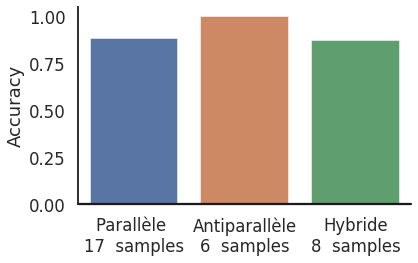

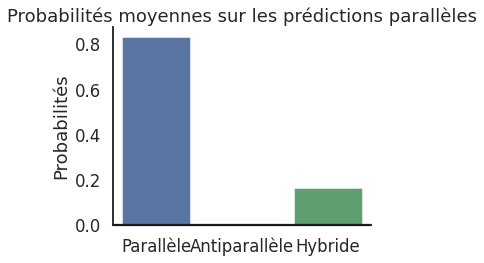

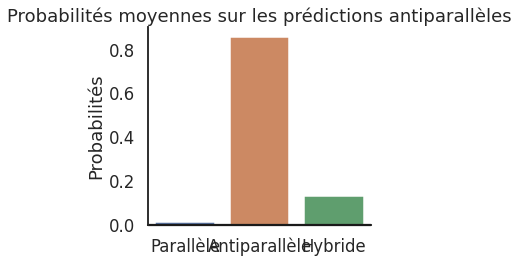

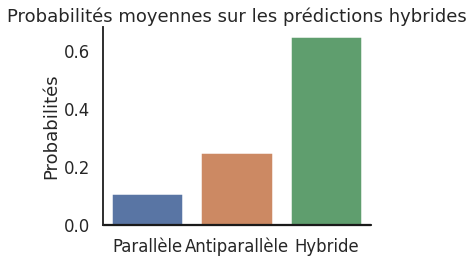

In [ ]:
multi_model_cnn.plot_results(inputsA_test,inputsB_test,targets_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


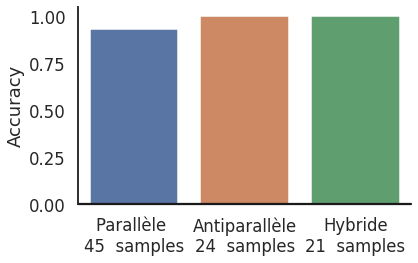

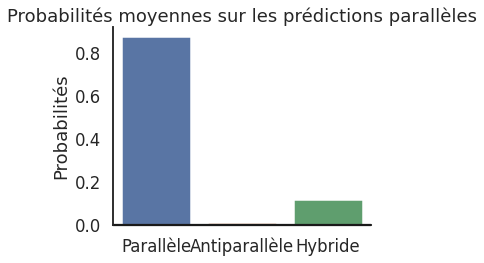

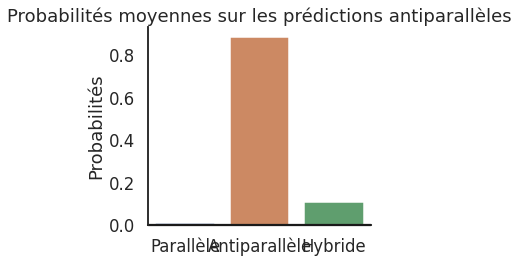

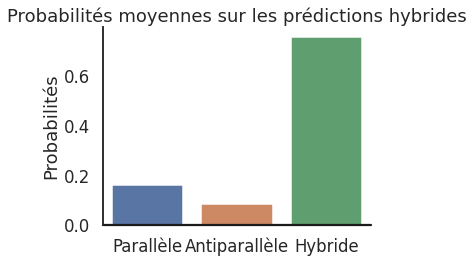

In [ ]:
multi_model_cnn.plot_results(inputsA_train,inputsB_train,targets_train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#multi_model_cnn.model.save("/content/drive/MyDrive/stage_lbpa/model/multimodal2")

Mounted at /content/drive
INFO:tensorflow:Assets written to: /content/drive/MyDrive/stage_lbpa/model/multimodal2/assets


In [ ]:
def predict(pred,labels,tresh):
  acc = [0,0,0]
  n_class_tot = [0,0,0]
  n_class = [0,0,0]
  for i in range(len(pred)):
    lab = int(labels[i])
    predk = pred[i]
    n_class_tot[lab] += 1
    if np.max(predk) > tresh:
      n_class[lab] += 1
      if np.argmax(predk) == lab:
        acc[lab] += 1
  for i in range(3):
    if n_class[i] != 0:
     acc[i]/=n_class[i]
    else:
      acc[i] = 0

  return np.array(acc),np.array(n_class)/np.array(n_class_tot)

colors = ["blue","green","red"]
Labels = ["Parallèle","Antiparallèle","Hybride"]

pred = multi_model_cnn.model.predict([inputsA_test,inputsB_test])

N = 20

x = np.linspace(0.3,0.9,N)
Acc = np.zeros((N,3))
Ratio = np.zeros((N,3))
for k in range(N):
  acc,ratio = predict(pred,targets_test,x[k])
  Acc[k] = acc
  Ratio[k] = ratio

plt.figure()
for k in range(3):
  plt.figure()
  plt.plot(x,Acc[:,k],color = colors[k],label = "Accuracy")
  plt.plot(x,Ratio[:,k],marker = "*",color = colors[k],label = "Ratio d'acceptation")
  plt.legend()
  plt.title("Accuracy sur "+Labels[k]+" en fonction du seuil d'acceptation de prédiction")
  plt.show()




ValueError: ignored

In [ ]:
## test

# from google.colab import drive
# drive.mount('/content/drive')

datatest = My_data(np.loadtxt("data_test.txt"))

#model = tf.keras.models.load_model("/content/drive/MyDrive/stage_lbpa/model/multimodal2")

testA, testB, targets, inputsA_test, inputsB_test, targets_test  = create_data2(datatest.data,len(datatest.data))

multi_model_cnn.model.evaluate([testA,testB],targets)


1/1 [==============================] - 0s 21ms/step - loss: 2.1903 - sparse_categorical_accuracy: 0.1000


[2.1902694702148438, 0.10000000149011612]